In [1]:
import numpy as np
import pandas as pd
import pickle

In [2]:
# read in full data
data= pd.read_csv('../GenomeCRISPR_full05112017.csv')

# read in sample data
#data= pd.read_csv('../GenomeCRISPR_full05112017_small.csv')

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# filter for top pubmed 29083409
toppub_all_data = data[data['pubmed'] ==29083409]
# filter for data from doench paper
d = data[data['pubmed'] ==26780180]

In [4]:
# groupby celline and sequence, toppub
toppub_grouped = toppub_all_data.groupby(['sequence','symbol']).median()['effect'].reset_index()
# groupby celline and sequence, doench
d_grouped = d.groupby(['sequence','symbol']).median()['effect'].reset_index()

In [5]:
# groupby sequence to get unique seqs by gene, toppub
groupby_seq = toppub_grouped.groupby(['sequence']).count().reset_index()
groupby_gene = toppub_grouped.groupby(['symbol']).count().reset_index()
# keeping only sequence column, toppub
unique_seq_toppub = groupby_seq['sequence']
groupby_gene = groupby_gene['symbol']

# get unique seqs, doench
d_groupby_seq = d_grouped.groupby(['sequence']).count().reset_index()
unique_seq_d = d_groupby_seq['sequence']

In [6]:
# join toppub data and doench data
joined = d_grouped.merge(toppub_grouped, left_on="sequence", right_on="sequence", how="inner")

In [7]:
# calc diff between effects from 2 experiments
joined["diff"] = joined["effect_x"] - joined["effect_y"]

In [43]:
# write all doench to pickle
pickle.dump(d_grouped["sequence"], open("../d_all_data.p", "wb"))
pickle.dump(d_grouped["effect"], open("../d_all_labels.p", "wb"))


# write only overalpped doench to pickle
pickle.dump(joined["sequence"], open("../d_intersect_data.p", "wb"))
pickle.dump(joined["effect_x"], open("../d_intersect_labels.p", "wb"))

In [8]:
# for intersection seqs, plot effect scores from both pubs
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(joined["effect_x"], joined["effect_y"], alpha=0.02)
z = np.polyfit(joined["effect_x"], joined["effect_y"],1)
p = np.poly1d(z)
plt.plot(joined["effect_x"], p(joined["effect_x"]), "r--")

plt.xlabel("Doench et al. effect size")
plt.ylabel("Meyers et al. (pubmed1) effect size")

plt.show()

<Figure size 640x480 with 1 Axes>

In [31]:
# calc spearman corr
import scipy.stats as st
st.spearmanr(joined["effect_x"], joined["effect_y"])

SpearmanrResult(correlation=0.6638872742071942, pvalue=0.0)

In [9]:
# one_hot function

e_dict = {'A':[1,0,0,0], 'C':[0,1,0,0], 'G':[0,0,1,0], 'T':[0,0,0,1]}

def one_hot(x):
    return e_dict[x]

In [10]:
# onehot encode the unique seqs, toppub
one_hot_un_seq = unique_seq_toppub.apply(lambda x: map(one_hot, x))
# doench
one_hot_d = unique_seq_d.apply(lambda x: map(one_hot, x))

In [11]:
# reset indices and append one_hot to df with seq, toppub
unique_seq_toppub = unique_seq_toppub.reset_index()
one_hot_un_seq = one_hot_un_seq.reset_index()
groupby_gene = groupby_gene.reset_index()
unique_seq_toppub['one_hot'] = one_hot_un_seq['sequence']
# doench
# reset indices and append one_hot to df with seq
unique_seq_d = unique_seq_d.reset_index()
one_hot_d = one_hot_d.reset_index()
unique_seq_d['one_hot'] = one_hot_d['sequence']

In [12]:
# merge one hot encoding to data
toppub_one_hot = toppub_grouped.merge(unique_seq_toppub,left_on="sequence",right_on="sequence", how="left")
d_one_hot = d_grouped.merge(unique_seq_d,left_on="sequence",right_on="sequence", how="left")

In [13]:
# merge gene encoding to data # toppub only
toppub_one_hot = toppub_one_hot.merge(groupby_gene,left_on="symbol",right_on="symbol", how="left")

In [76]:
# one hot features without gene, toppub
features_no_gene = np.ndarray(shape=(toppub_one_hot.shape[0],23,4), dtype=int)
for i in range(toppub_one_hot.shape[0]):
    for j in range(len(toppub_one_hot['one_hot'][i])):
        features_no_gene[i][j] = toppub_one_hot['one_hot'][i][j]
        
# one hot features without gene, toppub
features_d = np.ndarray(shape=(d_one_hot.shape[0],23,4), dtype=int)
for i in range(d_one_hot.shape[0]):
    for j in range(len(d_one_hot['one_hot'][i])):
        features_d[i][j] = d_one_hot['one_hot'][i][j]

In [ ]:
# save to pickle
pickle.dump(features_no_gene, open("../features_no_gene.p", "wb"))

In [14]:
# one hot features with gene # toppub only
# create empty numpy matrix for storing one hot features
features = np.ndarray(shape=(toppub_one_hot.shape[0],23,5), dtype=int)
# append gene to each one hot nucleotide
for i in range(toppub_one_hot.shape[0]):
    for j in range(len(toppub_one_hot['one_hot'][i])):
        features[i][j] = toppub_one_hot['one_hot'][i][j] + [toppub_one_hot['index_y'][i]]

In [15]:
toppub_one_hot.head()

,sequence,symbol,effect,index_x,one_hot,index_y
0,AAAAAAATCCAGCAATGCAGAGG,SHOC2,-1.0,0,"[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,...",14001
1,AAAAAACCCGTAGATAGCCTCGG,NDUFA12,-1.0,1,"[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,...",9936
2,AAAAAAGAAGAAAAAACCAGAGG,SDAD1,-5.0,2,"[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,...",13701
3,AAAAAAGCTCAAGAAGGAGGCGG,FAM98A,1.0,3,"[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,...",5316
4,AAAAAAGGCTGTAAAAGCGTGGG,ZNF253,-3.0,4,"[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,...",17743


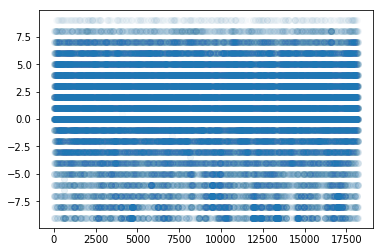

In [21]:
plt.scatter(toppub_one_hot['index_y'],toppub_one_hot['effect'], alpha=0.02)

In [ ]:
pickle.dump(features, open("../features.p", "wb"))

In [77]:
# for regression
def convert_labels(y):
    return (y + 10)/float(20)

In [78]:
# regression labels
labels = toppub_one_hot['effect']
labels = np.array(list(map(lambda x: convert_labels(x), labels)))
# doench
labels_d = d_one_hot['effect']
labels_d = np.array(list(map(lambda x: convert_labels(x), labels_d)))

In [79]:
# 21-label classification labels
num_classes=21
labels_c = toppub_one_hot['effect']
labels_c = np.array(list(map(lambda x: int(x+10), labels_c)))
labels_c = np.eye(num_classes)[labels_c]
# doench
labels_d21 = d_one_hot['effect']
labels_d21 = np.array(list(map(lambda x: int(x+10), labels_d21)))
labels_d21 = np.eye(num_classes)[labels_d21]

In [80]:
# 3-label classification labels
num_classes=3
labels_3 = toppub_one_hot['effect']
labels_3 = np.array(list(map(lambda x: int((x+10)/7), labels_3)))
labels_3 = np.eye(num_classes)[labels_3]
# doench
labels_d3 = d_one_hot['effect']
labels_d3 = np.array(list(map(lambda x: int((x+10)/7), labels_d3)))
labels_d3 = np.eye(num_classes)[labels_d3]

In [88]:
# for doench data, labels_d, labels_d21, labelsd_3
pickle.dump(features_d, open("../d_data.p", "wb"))

pickle.dump(labels_d, open("../d_labels_r.p", "wb"))
pickle.dump(labels_d21, open("../d_labels_21.p", "wb"))
pickle.dump(labels_d3, open("../d_labels_3.p", "wb"))

In [ ]:
########################### for toppub only ############################

In [ ]:
# split into training and testing for with gene, regression
np.random.seed(23)
msk = np.random.rand(len(features)) < 0.8

train_data = features[msk]
train_labels = labels[msk]

test_val_data = features[~msk]
test_val_labels = labels[~msk]

np.random.seed(23)
msk = np.random.rand(len(test_val_data)) < 0.5
test_data = test_val_data[msk]
test_labels = test_val_labels[msk]

val_data = test_val_data[~msk]
val_labels = test_val_labels[~msk]

# for with gene, regression
pickle.dump(train_data, open("../train_data_GR.p", "wb"))
pickle.dump(train_labels, open("../train_labels_GR.p", "wb"))

pickle.dump(test_data, open("../test_data_GR.p", "wb"))
pickle.dump(test_labels, open("../test_labels_GR.p", "wb"))

pickle.dump(val_data, open("../val_data_GR.p", "wb"))
pickle.dump(val_labels, open("../val_labels_GR.p", "wb"))

In [ ]:
# split into training and testing for no gene, regression
np.random.seed(23)
msk = np.random.rand(len(features_no_gene)) < 0.8

train_data = features_no_gene[msk]
train_labels = labels[msk]

test_val_data = features_no_gene[~msk]
test_val_labels = labels[~msk]

np.random.seed(23)
msk = np.random.rand(len(test_val_data)) < 0.5
test_data = test_val_data[msk]
test_labels = test_val_labels[msk]

val_data = test_val_data[~msk]
val_labels = test_val_labels[~msk]

# for with no gene, regression
pickle.dump(train_data, open("../train_data_NR.p", "wb"))
pickle.dump(train_labels, open("../train_labels_NR.p", "wb"))

pickle.dump(test_data, open("../test_data_NR.p", "wb"))
pickle.dump(test_labels, open("../test_labels_NR.p", "wb"))

pickle.dump(val_data, open("../val_data_NR.p", "wb"))
pickle.dump(val_labels, open("../val_labels_NR.p", "wb"))

In [ ]:
# split into training and testing for with gene, 21 classes
np.random.seed(23)
msk = np.random.rand(len(features)) < 0.8

train_data = features[msk]
train_labels = labels_c[msk]

test_val_data = features[~msk]
test_val_labels = labels_c[~msk]

np.random.seed(23)
msk = np.random.rand(len(test_val_data)) < 0.5
test_data = test_val_data[msk]
test_labels = test_val_labels[msk]

val_data = test_val_data[~msk]
val_labels = test_val_labels[~msk]

# for with gene, regression
pickle.dump(train_data, open("../train_data_G21.p", "wb"))
pickle.dump(train_labels, open("../train_labels_G21.p", "wb"))

pickle.dump(test_data, open("../test_data_G21.p", "wb"))
pickle.dump(test_labels, open("../test_labels_G21.p", "wb"))

pickle.dump(val_data, open("../val_data_G21.p", "wb"))
pickle.dump(val_labels, open("../val_labels_G21.p", "wb"))

In [ ]:
# split into training and testing for with gene, 3 classes
np.random.seed(23)
msk = np.random.rand(len(features)) < 0.8

train_data = features[msk]
train_labels = labels_3[msk]

test_val_data = features[~msk]
test_val_labels = labels_3[~msk]

np.random.seed(23)
msk = np.random.rand(len(test_val_data)) < 0.5
test_data = test_val_data[msk]
test_labels = test_val_labels[msk]

val_data = test_val_data[~msk]
val_labels = test_val_labels[~msk]

# for with gene, regression
pickle.dump(train_data, open("../train_data_G3.p", "wb"))
pickle.dump(train_labels, open("../train_labels_G3.p", "wb"))

pickle.dump(test_data, open("../test_data_G3.p", "wb"))
pickle.dump(test_labels, open("../test_labels_G3.p", "wb"))

pickle.dump(val_data, open("../val_data_G3.p", "wb"))
pickle.dump(val_labels, open("../val_labels_G3.p", "wb"))

In [ ]:
# split into training and testing for no gene, 21 classes
np.random.seed(23)
msk = np.random.rand(len(features_no_gene)) < 0.8

train_data = features_no_gene[msk]
train_labels = labels_c[msk]

test_val_data = features_no_gene[~msk]
test_val_labels = labels_c[~msk]

np.random.seed(23)
msk = np.random.rand(len(test_val_data)) < 0.5
test_data = test_val_data[msk]
test_labels = test_val_labels[msk]

val_data = test_val_data[~msk]
val_labels = test_val_labels[~msk]

# for with no gene, regression
pickle.dump(train_data, open("../train_data_N21.p", "wb"))
pickle.dump(train_labels, open("../train_labels_N21.p", "wb"))

pickle.dump(test_data, open("../test_data_N21.p", "wb"))
pickle.dump(test_labels, open("../test_labels_N21.p", "wb"))

pickle.dump(val_data, open("../val_data_N21.p", "wb"))
pickle.dump(val_labels, open("../val_labels_N21.p", "wb"))

In [ ]:
# split into training and testing for no gene, 3 classes
np.random.seed(23)
msk = np.random.rand(len(features_no_gene)) < 0.8

train_data = features_no_gene[msk]
train_labels = labels_3[msk]

test_val_data = features_no_gene[~msk]
test_val_labels = labels_3[~msk]

np.random.seed(23)
msk = np.random.rand(len(test_val_data)) < 0.5
test_data = test_val_data[msk]
test_labels = test_val_labels[msk]

val_data = test_val_data[~msk]
val_labels = test_val_labels[~msk]

# for with no gene, regression
pickle.dump(train_data, open("../train_data_N3.p", "wb"))
pickle.dump(train_labels, open("../train_labels_N3.p", "wb"))

pickle.dump(test_data, open("../test_data_N3.p", "wb"))
pickle.dump(test_labels, open("../test_labels_N3.p", "wb"))

pickle.dump(val_data, open("../val_data_N3.p", "wb"))
pickle.dump(val_labels, open("../val_labels_N3.p", "wb"))

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

In [ ]:
# for with gene
pickle.dump(train_data, open("../train_data.p", "wb"))
pickle.dump(train_labels, open("../train_labels.p", "wb"))

pickle.dump(test_data, open("../test_data.p", "wb"))
pickle.dump(test_labels, open("../test_labels.p", "wb"))

pickle.dump(val_data, open("../val_data.p", "wb"))
pickle.dump(val_labels, open("../val_labels.p", "wb"))

In [ ]:
# for classification without gene
pickle.dump(train_data, open("../train_data2.p", "wb"))
pickle.dump(train_labels, open("../train_labels2.p", "wb"))

pickle.dump(test_data, open("../test_data2.p", "wb"))
pickle.dump(test_labels, open("../test_labels2.p", "wb"))

pickle.dump(val_data, open("../val_data2.p", "wb"))
pickle.dump(val_labels, open("../val_labels2.p", "wb"))